<a href="https://colab.research.google.com/github/isabellacadisco/rps-image-classification/blob/master/RPS_mock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

0) Setup

In [1]:
# Colab: GPU check
import torch, sys, os, shutil, zipfile, random, math, time
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

!pip -q install kaggle --upgrade


PyTorch: 2.8.0+cu126
CUDA available: True


1) Download data

In [8]:
import matplotlib.pyplot as plt

In [8]:
import os, pathlib, json, subprocess
from google.colab import files

In [10]:
DATA_DIR = pathlib.Path("/content/data_rps")
#RAW_DIR = DATA_DIR / "raw" # forse potrebbero servirci dopo quando diamo una struttura
#PROC_DIR = DATA_DIR / "processed" # forse potrebbero servirci dopo quando diamo una struttura
#PROC_DIR.mkdir(parents=True, exist_ok=True)

In [7]:
if pathlib.Path("/root/.kaggle/kaggle.json").exists():
  print("ok")
else:
  # Upload your Kaggle API key (kaggle.json)
  # You can get it from your Kaggle account -> Settings -> Create New API Token
  files.upload()  # Choose kaggle.json
  # Move it to the correct location
  !mkdir -p ~/.kaggle
  !mv kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json

ok


In [15]:
# download dataset
!kaggle datasets download -d drgfreeman/rockpaperscissors

Dataset URL: https://www.kaggle.com/datasets/drgfreeman/rockpaperscissors
License(s): CC-BY-SA-4.0
 93% 284M/306M [00:02<00:00, 103MB/s] 
100% 306M/306M [00:02<00:00, 127MB/s]


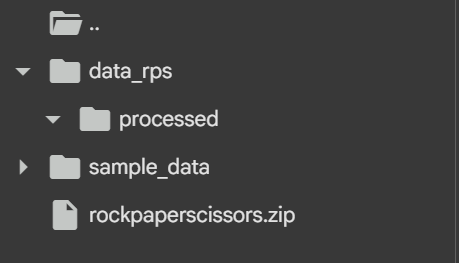

In [16]:
# Unzip it in data_rps
!unzip -q rockpaperscissors.zip -d data_rps

In [18]:
# inspect structure
import os
from PIL import Image
data_dir = "data_rps/rps-cv-images"  # main folder containing rock/paper/scissors
classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
print(f"Classes found: {classes}\n")

Classes found: ['rock', 'scissors', 'paper']



In [19]:
# Count total images per class
for cls in classes:
    count = len(os.listdir(os.path.join(data_dir, cls)))
    print(f"{cls}: {count} images")

# Count total images
total = sum(len(os.listdir(os.path.join(data_dir, c))) for c in classes)
print(f"\nTotal images: {total}")

rock: 726 images
scissors: 750 images
paper: 712 images

Total images: 2188


In [20]:
# Check image dimensions
sample_path = os.path.join(data_dir, classes[0], os.listdir(os.path.join(data_dir, classes[0]))[0])
img = Image.open(sample_path)
print(f"\nSample image size: {img.size} (width, height)")
print(f"Mode (color channels): {img.mode}")


Sample image size: (300, 200) (width, height)
Mode (color channels): RGB


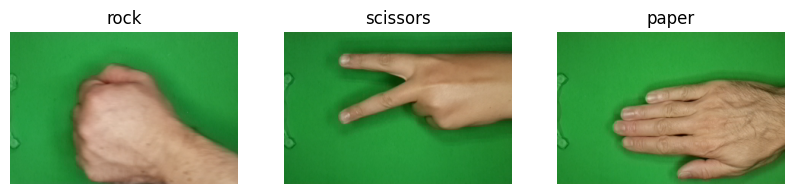

In [21]:
# Visualize examples

fig, axs = plt.subplots(1, 3, figsize=(10, 4))
for i, cls in enumerate(classes):
    img_path = os.path.join(data_dir, cls, os.listdir(os.path.join(data_dir, cls))[0])
    axs[i].imshow(Image.open(img_path))
    axs[i].set_title(cls)
    axs[i].axis("off")

plt.show()

In [23]:
import os

# Percorsi delle due directory
dir1 = "data_rps"
dir2 = "data_rps/rps-cv-images"

# Classi da confrontare
classes = ["paper", "rock", "scissors"]

for cls in classes:
    path1 = os.path.join(dir1, cls)
    path2 = os.path.join(dir2, cls)

    # Controlla che entrambe le cartelle esistano
    if not os.path.exists(path1):
        print(f"❌ La cartella {path1} non esiste.")
        continue
    if not os.path.exists(path2):
        print(f"❌ La cartella {path2} non esiste.")
        continue

    # Lista dei file
    files1 = sorted(os.listdir(path1))
    files2 = sorted(os.listdir(path2))

    # Confronto dei file
    diff1 = set(files1) - set(files2)
    diff2 = set(files2) - set(files1)

    if not diff1 and not diff2:
        print(f"✅ Le cartelle '{cls}' sono uguali in entrambe le directory.")
    else:
        print(f"⚠️ Differenze trovate nella cartella '{cls}':")
        if diff1:
            print(f"  - Presenti solo in {dir1}/{cls}: {len(diff1)} file")
        if diff2:
            print(f"  - Presenti solo in {dir2}/{cls}: {len(diff2)} file")


✅ Le cartelle 'paper' sono uguali in entrambe le directory.
✅ Le cartelle 'rock' sono uguali in entrambe le directory.
✅ Le cartelle 'scissors' sono uguali in entrambe le directory.


In [45]:
RAW_DIR = pathlib.Path("/content/raw")

In [25]:
import shutil

source_dir = "data_rps/rps-cv-images"
destination_dir = RAW_DIR # Using the RAW_DIR variable defined earlier

# Create the destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Copy the contents of the source directory to the destination directory
for item in os.listdir(source_dir):
    s = os.path.join(source_dir, item)
    d = os.path.join(destination_dir, item)
    if os.path.isdir(s):
        shutil.copytree(s, d, dirs_exist_ok=True)
    else:
        shutil.copy2(s, d)

print(f"Contents of '{source_dir}' copied to '{destination_dir}'.")

Contents of 'data_rps/rps-cv-images' copied to '/content/raw'.


2) Preprocess data

In [16]:
PROC_DIR = ("/content/processed") # questa mi serve come riferimento sempre

In [28]:
# train, val, test split

In [17]:
import pathlib

SPLIT_DIR = pathlib.Path(PROC_DIR)
train_dir = pathlib.Path(SPLIT_DIR) / "train"
val_dir   = pathlib.Path(SPLIT_DIR) / "val"
test_dir  = pathlib.Path(SPLIT_DIR) / "test"

In [39]:
#Elimina le cartelle train_dir, val_dir e test_dir se esistono.
#Le ricrea vuote e pronte per essere riempite
for d in [train_dir, val_dir, test_dir]:
    if d.exists(): shutil.rmtree(d)
    d.mkdir(parents=True, exist_ok=True)

In [43]:
## TRAIN VAL TEST SPLIT - per ora uso sklearn, eventualmente cambio
from sklearn.model_selection import train_test_split
from pathlib import Path

def copy_split(src_root: Path, val_ratio=0.15, test_ratio=0.15):

    # Legge i nomi delle classi come sottocartelle in src_root e le crea in train/, val/, test
    classes = [d.name for d in src_root.iterdir() if d.is_dir()]
    classes = sorted(classes)
    for cls in classes:
        (train_dir/cls).mkdir(parents=True, exist_ok=True)
        (val_dir/cls).mkdir(parents=True, exist_ok=True)
        (test_dir/cls).mkdir(parents=True, exist_ok=True)

        imgs = sorted([p for p in (src_root/cls).glob("*") if p.suffix.lower() in {".png",".jpg",".jpeg"}])

        train_imgs, temp = train_test_split(imgs, test_size=(val_ratio+test_ratio), random_state=SEED, stratify=None)
        rel = test_ratio / (val_ratio+test_ratio)
        val_imgs, test_imgs = train_test_split(temp, test_size=rel, random_state=SEED, stratify=None)

        for p in train_imgs: shutil.copy(p, train_dir/cls/p.name)
        for p in val_imgs:   shutil.copy(p, val_dir/cls/p.name)
        for p in test_imgs:  shutil.copy(p, test_dir/cls/p.name)

In [46]:
copy_split(RAW_DIR)

quick exploration

In [18]:
# Check distribution of classes in paper, rock, scissors
from pathlib import Path

IMG_EXTS = {".png", ".jpg", ".jpeg"}

def _count_in_dir(d: Path):
    if not d.exists():
        return 0
    return sum(1 for p in d.glob("*") if p.suffix.lower() in IMG_EXTS)

def show_split_stats(train_dir: Path, val_dir: Path, test_dir: Path):
    classes = sorted({p.name for p in train_dir.iterdir() if p.is_dir()}
                     | {p.name for p in val_dir.iterdir() if p.is_dir()}
                     | {p.name for p in test_dir.iterdir() if p.is_dir()})

    print(f"Classi trovate: {classes}\n")
    header = f"{'classe':<15}{'train':>8}{'val':>8}{'test':>8}{'tot':>8}   {'%train':>7}{'%val':>7}{'%test':>7}"
    print(header)
    print("-"*len(header))

    totals = {"train":0, "val":0, "test":0, "all":0}

    for cls in classes:
        t = _count_in_dir(train_dir/cls)
        v = _count_in_dir(val_dir/cls)
        te = _count_in_dir(test_dir/cls)
        tot = t+v+te
        totals["train"] += t
        totals["val"]   += v
        totals["test"]  += te
        totals["all"]   += tot

        p_train = (t/tot*100) if tot else 0.0
        p_val   = (v/tot*100) if tot else 0.0
        p_test  = (te/tot*100) if tot else 0.0

        print(f"{cls:<15}{t:>8}{v:>8}{te:>8}{tot:>8}   {p_train:6.1f}%{p_val:6.1f}%{p_test:6.1f}%")

    print("-"*len(header))
    P = lambda n: (n/totals["all"]*100) if totals["all"] else 0.0
    print(f"{'TOTALE':<15}{totals['train']:>8}{totals['val']:>8}{totals['test']:>8}{totals['all']:>8}   "
          f"{P(totals['train']):6.1f}%{P(totals['val']):6.1f}%{P(totals['test']):6.1f}%")

# Esegui dopo copy_split(...)
show_split_stats(train_dir, val_dir, test_dir)


Classi trovate: ['paper', 'rock', 'scissors']

classe            train     val    test     tot    %train   %val  %test
-----------------------------------------------------------------------
paper               498     107     107     712     69.9%  15.0%  15.0%
rock                508     109     109     726     70.0%  15.0%  15.0%
scissors            525     112     113     750     70.0%  14.9%  15.1%
-----------------------------------------------------------------------
TOTALE             1531     328     329    2188     70.0%  15.0%  15.0%


In [19]:
import glob
from collections import Counter

def count_images(root):
    counts = {}
    for cls_dir in sorted(glob.glob(f"{root}/*")):
        if os.path.isdir(cls_dir):
            cls = os.path.basename(cls_dir)
            n = len(glob.glob(f"{cls_dir}/*"))
            counts[cls] = n
    return counts

train_counts = count_images(train_dir)
val_counts   = count_images(val_dir)
test_counts  = count_images(test_dir)

print("Train counts:", train_counts)
print("Val counts:  ", val_counts)
print("Test counts: ", test_counts)
print("Total images:", sum(train_counts.values()) + sum(val_counts.values()) + sum(test_counts.values()))


Train counts: {'paper': 498, 'rock': 508, 'scissors': 525}
Val counts:   {'paper': 107, 'rock': 109, 'scissors': 112}
Test counts:  {'paper': 107, 'rock': 109, 'scissors': 113}
Total images: 2188


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [14]:
# EXECUTE ONLY FIRST TIME, THEN TAKE DATA FROM DRIVE
# copy to drive train, val, test
#!cp -r /content/processed /content/drive/MyDrive/RPS-data/processed
# copy to drive raw data
#!cp -r /content/raw /content/drive/MyDrive/RPS-data/raw

In [15]:
# copy processed data from drive to colab
!cp -r /content/drive/MyDrive/RPS-data/processed /content/processed

In [12]:
classes = ['rock', 'scissors', 'paper']
from PIL import Image

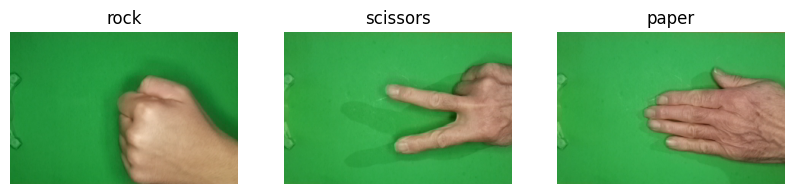

In [13]:
# Visualize examples from drive
processed_dir_from_drive = "/content/drive/MyDrive/RPS-data/processed/val"

fig, axs = plt.subplots(1, 3, figsize=(10, 4))
for i, cls in enumerate(classes):
    img_path = os.path.join(processed_dir_from_drive, cls, os.listdir(os.path.join(processed_dir_from_drive, cls))[0])
    axs[i].imshow(Image.open(img_path))
    axs[i].set_title(cls)
    axs[i].axis("off")

plt.show()

3) Transform, Datasets, Dataloaders

In [20]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [21]:
IMG_SIZE = 64 #128
BATCH_SIZE = 64

In [22]:
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    # Augment (optional but helpful)
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])  # scale to [-1,1]
])

In [23]:
test_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

In [24]:
train_ds = datasets.ImageFolder(train_dir, transform=train_tfms)
val_ds   = datasets.ImageFolder(val_dir,   transform=test_tfms)
test_ds  = datasets.ImageFolder(test_dir,  transform=test_tfms)

In [25]:
train_ds

Dataset ImageFolder
    Number of datapoints: 1531
    Root location: /content/processed/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1), saturation=None, hue=None)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [26]:
val_ds

Dataset ImageFolder
    Number of datapoints: 328
    Root location: /content/processed/val
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [27]:
test_ds

Dataset ImageFolder
    Number of datapoints: 329
    Root location: /content/processed/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [28]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

In [29]:
CLASS_NAMES = train_ds.classes

In [30]:
NUM_CLASSES = len(CLASS_NAMES)
print("Classes:", CLASS_NAMES)

Classes: ['paper', 'rock', 'scissors']


4) CNN architectures - increasing complexity

NB: le forward si potrebbero uniformare

In [31]:
import torch.nn as nn
import torch.nn.functional as F

# 1) TinyCNN – fastest, baseline
class TinyCNN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), # 64x64
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),# 32x32
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2) # 16x16
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*(IMG_SIZE//8)*(IMG_SIZE//8), 128), nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

# 2) BaselineCNN – batchnorm + extra capacity
class BaselineCNN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        def block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1), nn.BatchNorm2d(out_c), nn.ReLU(),
                nn.Conv2d(out_c, out_c, 3, padding=1), nn.BatchNorm2d(out_c), nn.ReLU(),
                nn.MaxPool2d(2)
            )
        self.features = nn.Sequential(
            block(3, 32),    # 64x64
            block(32, 64),   # 32x32
            block(64, 128),  # 16x16
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*(IMG_SIZE//8)*(IMG_SIZE//8), 256), nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        return self.classifier(self.features(x))

# 3) DeepCNN – more filters, global average pooling (fewer params in head)
class DeepCNN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        def conv_bn_relu(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(),
            )
        self.stem = nn.Sequential(
            conv_bn_relu(3, 32), conv_bn_relu(32, 32), nn.MaxPool2d(2),   # 64x64
            conv_bn_relu(32, 64), conv_bn_relu(64, 64), nn.MaxPool2d(2),  # 32x32
            conv_bn_relu(64,128), conv_bn_relu(128,128), nn.MaxPool2d(2), # 16x16
            conv_bn_relu(128,256), nn.AdaptiveAvgPool2d(1)
        )
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        return self.head(self.stem(x))


5) Training & Evaluation Utilities

In [32]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct, n = 0.0, 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
        pred = logits.argmax(1)
        correct += (pred == yb).sum().item()
        n += xb.size(0)
    return total_loss/n, correct/n

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct, n = 0.0, 0, 0
    all_preds, all_targets = [], []
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = model(xb)
        loss = criterion(logits, yb)
        total_loss += loss.item() * xb.size(0)
        pred = logits.argmax(1)
        correct += (pred == yb).sum().item()
        n += xb.size(0)
        all_preds.append(pred.cpu())
        all_targets.append(yb.cpu())
    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()
    return total_loss/n, correct/n, all_preds, all_targets

def plot_curves(history, title="Training curves"):
    epochs = range(1, len(history["train_loss"])+1)
    plt.figure()
    plt.plot(epochs, history["train_loss"], label="train_loss")
    plt.plot(epochs, history["val_loss"], label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(title)
    plt.legend(); plt.show()

    plt.figure()
    plt.plot(epochs, history["train_acc"], label="train_acc")
    plt.plot(epochs, history["val_acc"], label="val_acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title(title)
    plt.legend(); plt.show()


6) Train Function + Small Hyperparameter Tuning (for one model)

In [33]:
def fit(model, train_loader, val_loader, epochs=10, lr=1e-3, wd=1e-4):
    model = model.to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    history = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[]}
    best_w = None
    best_val = -1.0

    for ep in range(1, epochs+1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        va_loss, va_acc, _, _ = evaluate(model, val_loader, criterion)
        history["train_loss"].append(tr_loss); history["val_loss"].append(va_loss)
        history["train_acc"].append(tr_acc);   history["val_acc"].append(va_acc)
        print(f"Epoch {ep:02d} | train_loss {tr_loss:.4f} acc {tr_acc:.3f} | val_loss {va_loss:.4f} acc {va_acc:.3f}")
        if va_acc > best_val:
            best_val = va_acc
            best_w = {k:v.cpu().clone() for k,v in model.state_dict().items()}
    if best_w is not None:
        model.load_state_dict(best_w)
    return model, history

# --- Mini hyperparameter sweep for BaselineCNN ---
def quick_tune_baseline():
    from copy import deepcopy
    results = []
    lrs = [3e-4, 1e-3, 3e-3]
    batches = [32, 64]

    for bs in batches:
        tr_loader = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=2, pin_memory=True)
        va_loader = DataLoader(val_ds,   batch_size=bs, shuffle=False, num_workers=2, pin_memory=True)
        for lr in lrs:
            print(f"\n[Probe] bs={bs} lr={lr}")
            model = BaselineCNN(NUM_CLASSES).to(DEVICE)
            criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
            # One quick epoch to gauge
            tr_loss, tr_acc = train_one_epoch(model, tr_loader, optimizer, criterion)
            va_loss, va_acc, _, _ = evaluate(model, va_loader, criterion)
            results.append(((bs, lr), va_acc))
            print(f"val_acc={va_acc:.3f}")
    # pick best
    best = max(results, key=lambda x: x[1])
    print("\nBest setting:", best)
    return best[0]  # (bs, lr)

best_bs, best_lr = quick_tune_baseline()
print("Chosen hyperparams -> batch_size:", best_bs, "learning_rate:", best_lr)

# Rebuild loaders with best batch size for final training
train_loader = DataLoader(train_ds, batch_size=best_bs, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=best_bs, shuffle=False, num_workers=2, pin_memory=True)



[Probe] bs=32 lr=0.0003
val_acc=0.866

[Probe] bs=32 lr=0.001
val_acc=0.869

[Probe] bs=32 lr=0.003
val_acc=0.454

[Probe] bs=64 lr=0.0003
val_acc=0.332

[Probe] bs=64 lr=0.001
val_acc=0.396

[Probe] bs=64 lr=0.003
val_acc=0.354

Best setting: ((32, 0.001), 0.8689024390243902)
Chosen hyperparams -> batch_size: 32 learning_rate: 0.001


7) Train All 3 Models & Compare

Epoch 01 | train_loss 0.9457 acc 0.532 | val_loss 0.4531 acc 0.896
Epoch 02 | train_loss 0.3336 acc 0.897 | val_loss 0.2512 acc 0.896
Epoch 03 | train_loss 0.1686 acc 0.947 | val_loss 0.1211 acc 0.963
Epoch 04 | train_loss 0.1349 acc 0.959 | val_loss 0.1032 acc 0.963
Epoch 05 | train_loss 0.0955 acc 0.975 | val_loss 0.0725 acc 0.966
Epoch 06 | train_loss 0.0919 acc 0.967 | val_loss 0.0683 acc 0.982
Epoch 07 | train_loss 0.0541 acc 0.984 | val_loss 0.0470 acc 0.988
Epoch 08 | train_loss 0.0513 acc 0.984 | val_loss 0.0402 acc 0.988


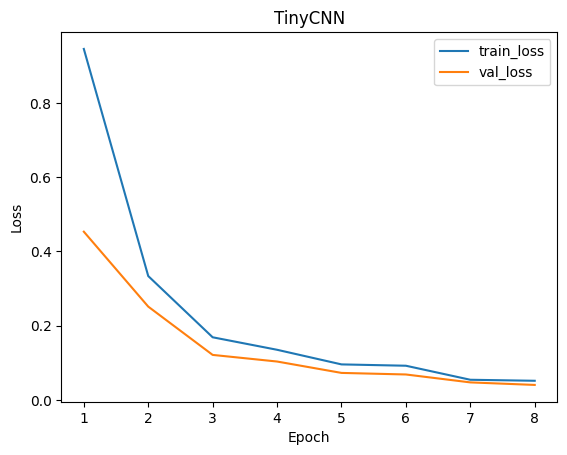

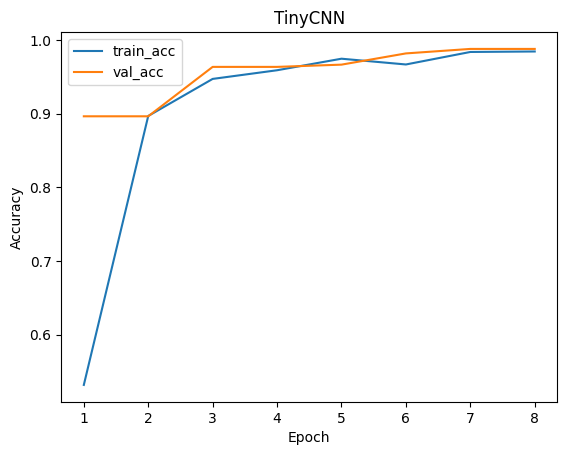

Epoch 01 | train_loss 1.3339 acc 0.596 | val_loss 0.7425 acc 0.707
Epoch 02 | train_loss 0.2064 acc 0.932 | val_loss 0.3176 acc 0.872
Epoch 03 | train_loss 0.1002 acc 0.974 | val_loss 0.0784 acc 0.976
Epoch 04 | train_loss 0.0696 acc 0.980 | val_loss 0.0620 acc 0.976
Epoch 05 | train_loss 0.0585 acc 0.980 | val_loss 0.0494 acc 0.991
Epoch 06 | train_loss 0.0466 acc 0.988 | val_loss 0.1635 acc 0.948
Epoch 07 | train_loss 0.0395 acc 0.990 | val_loss 0.0361 acc 0.988
Epoch 08 | train_loss 0.0461 acc 0.986 | val_loss 0.1127 acc 0.966
Epoch 09 | train_loss 0.0407 acc 0.989 | val_loss 0.1198 acc 0.960
Epoch 10 | train_loss 0.0297 acc 0.991 | val_loss 0.0461 acc 0.988


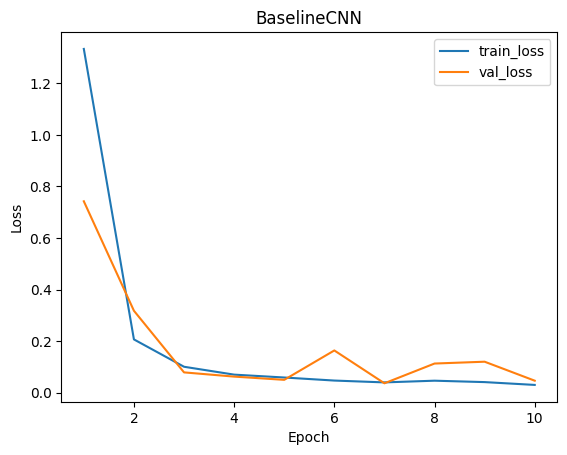

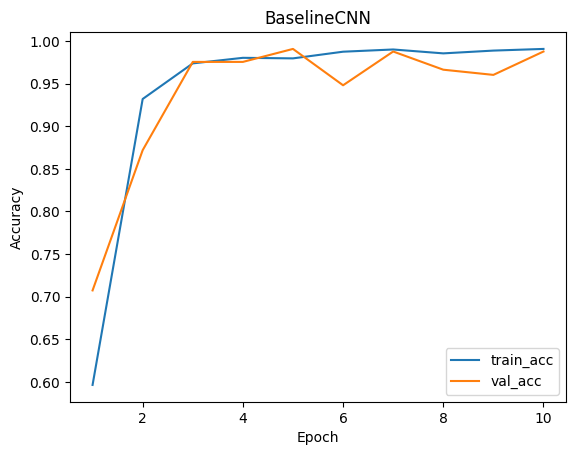

Epoch 01 | train_loss 0.3488 acc 0.903 | val_loss 0.2099 acc 0.933
Epoch 02 | train_loss 0.0862 acc 0.986 | val_loss 0.3105 acc 0.884
Epoch 03 | train_loss 0.0515 acc 0.993 | val_loss 0.0362 acc 0.994
Epoch 04 | train_loss 0.0582 acc 0.983 | val_loss 0.0781 acc 0.985
Epoch 05 | train_loss 0.0364 acc 0.991 | val_loss 0.0655 acc 0.979
Epoch 06 | train_loss 0.0460 acc 0.991 | val_loss 0.0457 acc 0.988
Epoch 07 | train_loss 0.0266 acc 0.995 | val_loss 0.0183 acc 0.997
Epoch 08 | train_loss 0.0118 acc 0.999 | val_loss 0.0221 acc 0.994
Epoch 09 | train_loss 0.0310 acc 0.993 | val_loss 0.0291 acc 0.991
Epoch 10 | train_loss 0.0264 acc 0.993 | val_loss 0.0277 acc 0.991
Epoch 11 | train_loss 0.0100 acc 0.999 | val_loss 0.0168 acc 0.994
Epoch 12 | train_loss 0.0328 acc 0.992 | val_loss 0.0127 acc 0.997


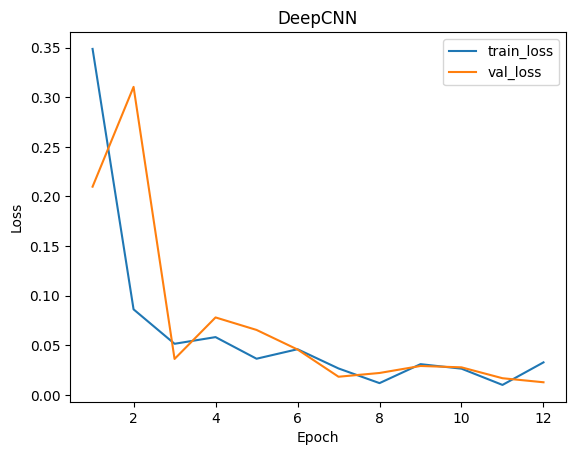

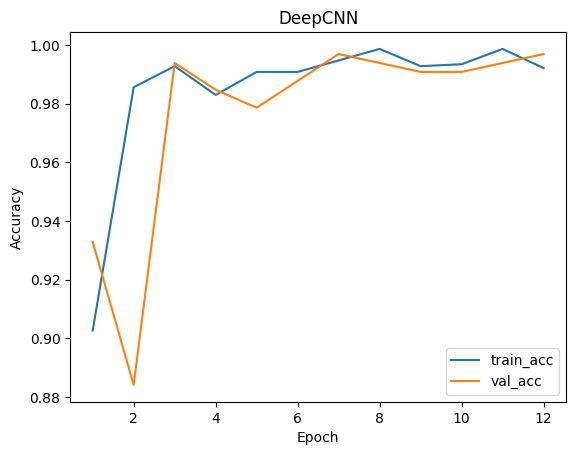

In [34]:
EPOCHS_TINY = 8
EPOCHS_BASE = 10
EPOCHS_DEEP = 12

# 1) TinyCNN
tiny = TinyCNN(NUM_CLASSES)
tiny, tiny_hist = fit(tiny, train_loader, val_loader, epochs=EPOCHS_TINY, lr=best_lr)
plot_curves(tiny_hist, "TinyCNN")

# 2) BaselineCNN (with tuned LR)
base = BaselineCNN(NUM_CLASSES)
base, base_hist = fit(base, train_loader, val_loader, epochs=EPOCHS_BASE, lr=best_lr)
plot_curves(base_hist, "BaselineCNN")

# 3) DeepCNN
deep = DeepCNN(NUM_CLASSES)
deep, deep_hist = fit(deep, train_loader, val_loader, epochs=EPOCHS_DEEP, lr=best_lr*0.5)
plot_curves(deep_hist, "DeepCNN")


=== Validation performance ===

[TinyCNN (Val)] loss=0.0470 acc=0.988
              precision    recall  f1-score   support

       paper      0.990     0.972     0.981       107
        rock      0.973     1.000     0.986       109
    scissors      1.000     0.991     0.996       112

    accuracy                          0.988       328
   macro avg      0.988     0.988     0.988       328
weighted avg      0.988     0.988     0.988       328



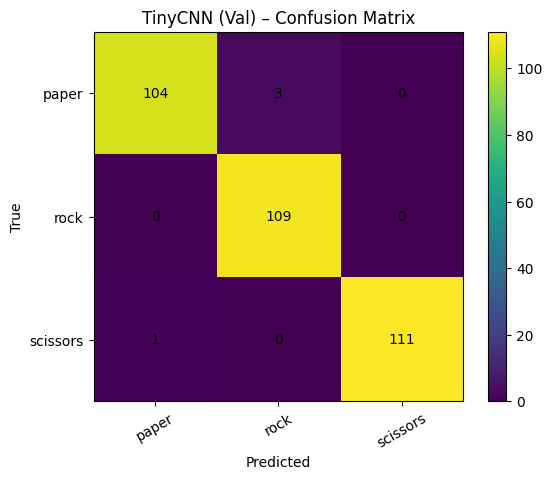


[BaselineCNN (Val)] loss=0.0494 acc=0.991
              precision    recall  f1-score   support

       paper      0.981     0.991     0.986       107
        rock      0.991     0.982     0.986       109
    scissors      1.000     1.000     1.000       112

    accuracy                          0.991       328
   macro avg      0.991     0.991     0.991       328
weighted avg      0.991     0.991     0.991       328



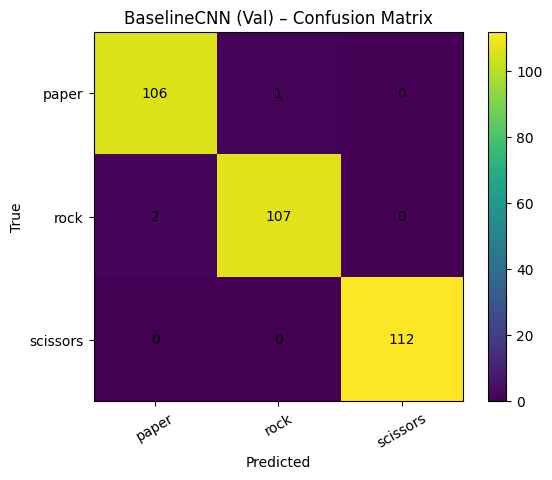


[DeepCNN (Val)] loss=0.0183 acc=0.997
              precision    recall  f1-score   support

       paper      1.000     0.991     0.995       107
        rock      0.991     1.000     0.995       109
    scissors      1.000     1.000     1.000       112

    accuracy                          0.997       328
   macro avg      0.997     0.997     0.997       328
weighted avg      0.997     0.997     0.997       328



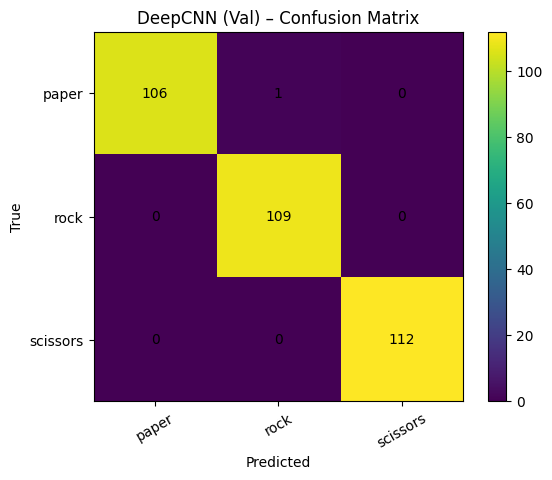

In [35]:
def eval_and_report(model, loader, title):
    criterion = nn.CrossEntropyLoss()
    loss, acc, preds, targets = evaluate(model.to(DEVICE), loader, criterion)
    print(f"\n[{title}] loss={loss:.4f} acc={acc:.3f}")
    print(classification_report(targets, preds, target_names=CLASS_NAMES, digits=3))
    cm = confusion_matrix(targets, preds)
    # Plot confusion matrix
    import numpy as np
    plt.figure()
    plt.imshow(cm)
    plt.title(f"{title} – Confusion Matrix")
    plt.xticks(range(NUM_CLASSES), CLASS_NAMES, rotation=30)
    plt.yticks(range(NUM_CLASSES), CLASS_NAMES)
    for i in range(NUM_CLASSES):
        for j in range(NUM_CLASSES):
            plt.text(j, i, cm[i,j], ha="center", va="center")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.colorbar(); plt.show()

print("\n=== Validation performance ===")
eval_and_report(tiny, val_loader, "TinyCNN (Val)")
eval_and_report(base, val_loader, "BaselineCNN (Val)")
eval_and_report(deep, val_loader, "DeepCNN (Val)")

In [37]:
tiny

TinyCNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=3, bias=True)
  )
)

In [39]:
base

BaselineCNN(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False

In [36]:
deep

DeepCNN(
  (stem): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (5): MaxPool2d(kernel_size=2, 

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
# save models to drive
torch.save(tiny.state_dict(), "/content/drive/MyDrive/RPS-data/models/tiny.pt")
torch.save(base.state_dict(), "/content/drive/MyDrive/RPS-data/models/base.pt")
torch.save(deep.state_dict(), "/content/drive/MyDrive/RPS-data/models/deep.pt")


[TinyCNN LOADED (Val)] loss=0.0470 acc=0.988
              precision    recall  f1-score   support

       paper      0.990     0.972     0.981       107
        rock      0.973     1.000     0.986       109
    scissors      1.000     0.991     0.996       112

    accuracy                          0.988       328
   macro avg      0.988     0.988     0.988       328
weighted avg      0.988     0.988     0.988       328



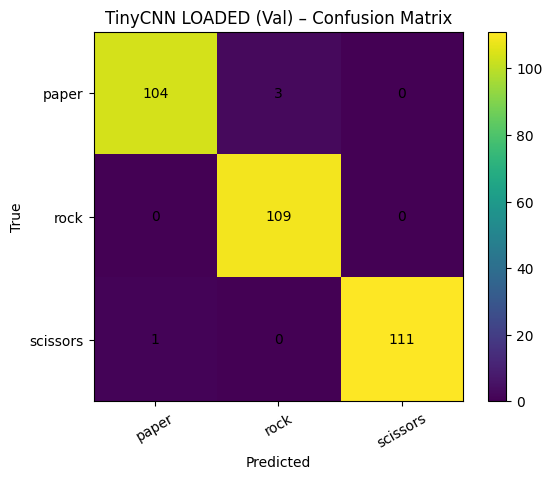

In [47]:
### to load the model later
tiny_loaded = TinyCNN()   # must match the exact architecture definition
tiny_loaded.load_state_dict(torch.load("/content/drive/MyDrive/RPS-data/models/tiny.pt"))
eval_and_report(tiny_loaded, val_loader, "TinyCNN LOADED (Val)")


8) Final Test Set Evaluation (Pick Best Model)

Selected best model by recent-val-acc avg: DeepCNN

[TEST] DeepCNN | loss=0.0139 acc=0.9970
              precision    recall  f1-score   support

       paper      1.000     1.000     1.000       107
        rock      0.991     1.000     0.995       109
    scissors      1.000     0.991     0.996       113

    accuracy                          0.997       329
   macro avg      0.997     0.997     0.997       329
weighted avg      0.997     0.997     0.997       329



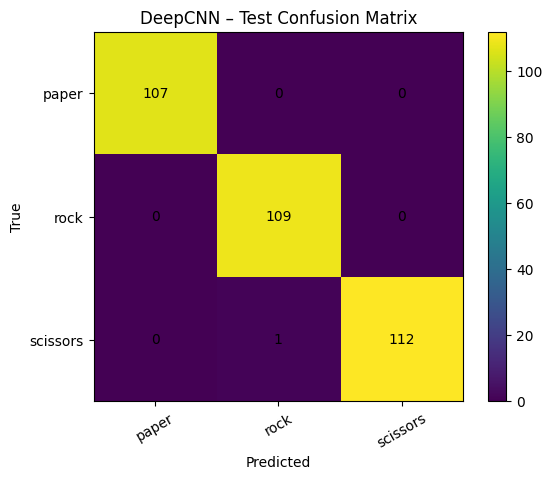

In [41]:
# Choose the model with highest val accuracy quickly:
val_scores = [
    ("TinyCNN", sum(tiny_hist["val_acc"][-3:])/3.0, tiny),
    ("BaselineCNN", sum(base_hist["val_acc"][-3:])/3.0, base),
    ("DeepCNN", sum(deep_hist["val_acc"][-3:])/3.0, deep),
]
val_scores.sort(key=lambda x: x[1], reverse=True)
best_name, _, best_model = val_scores[0]
print(f"Selected best model by recent-val-acc avg: {best_name}")

test_crit = nn.CrossEntropyLoss()
test_loss, test_acc, test_preds, test_targets = evaluate(best_model, test_loader, test_crit)
print(f"\n[TEST] {best_name} | loss={test_loss:.4f} acc={test_acc:.4f}")
print(classification_report(test_targets, test_preds, target_names=CLASS_NAMES, digits=3))

# Confusion matrix on test
cm = confusion_matrix(test_targets, test_preds)
plt.figure()
plt.imshow(cm)
plt.title(f"{best_name} – Test Confusion Matrix")
plt.xticks(range(NUM_CLASSES), CLASS_NAMES, rotation=30)
plt.yticks(range(NUM_CLASSES), CLASS_NAMES)
for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        plt.text(j, i, cm[i,j], ha="center", va="center")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.colorbar(); plt.show()


9) Misclassified Examples (Analysis)

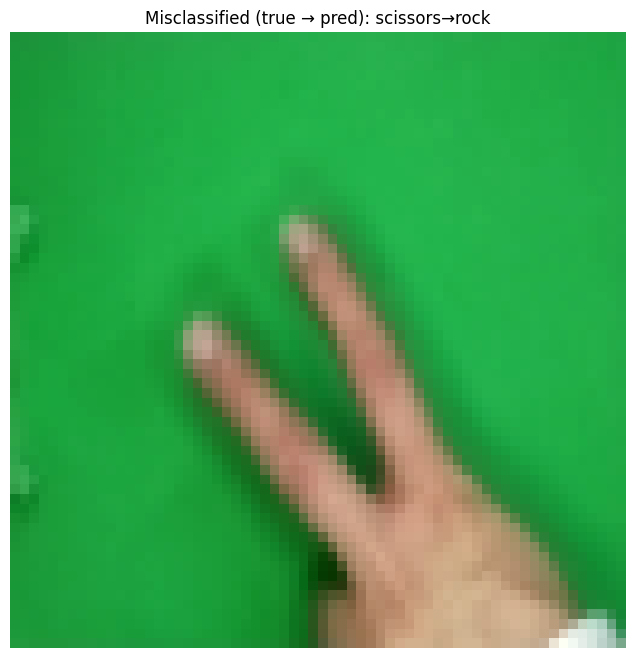

In [48]:
from torchvision.utils import make_grid

@torch.no_grad()
def collect_misclassified(model, loader, k=12):
    model.eval()
    xs, ys, ps = [], [], []
    for xb, yb in loader:
        logits = model(xb.to(DEVICE))
        pred = logits.argmax(1).cpu()
        mis = pred != yb
        for i in torch.where(mis)[0][:k - len(xs)]:
            xs.append(xb[i])
            ys.append(yb[i].item())
            ps.append(pred[i].item())
            if len(xs) >= k: break
        if len(xs) >= k: break
    if not xs: return None
    grid = make_grid(torch.stack(xs), nrow=4, padding=2, normalize=True)
    return grid, ys, ps

res = collect_misclassified(best_model, test_loader, k=12)
if res is None:
    print("No misclassifications found in sampled batch.")
else:
    grid, ys, ps = res
    plt.figure(figsize=(8,8))
    plt.imshow(grid.permute(1,2,0))
    plt.axis("off")
    plt.title("Misclassified (true → pred): " + ", ".join([f"{CLASS_NAMES[y]}→{CLASS_NAMES[p]}" for y,p in zip(ys,ps)]))
    plt.show()
